In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder

from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score

In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [ ]:
#Remove the ID column
df.info()
df.drop('id', axis=1, inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=0))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

### Label Encode Binary Columns

In [ ]:
##Label Encode Binary
residence_type = df['Residence_type'].unique()
ever_married = df['ever_married'].unique()
le = LabelEncoder()

le.fit(residence_type)
df['Residence_type'] = le.transform(df['Residence_type'])

le.fit(ever_married)
df['ever_married'] = le.transform(df['ever_married'])

In [ ]:
df
#Label Encode -> One Hot Encode -> PCA -> Splitting -> Outlier Detection -> SMOTE X_train and y_train -> Bayes Training

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,29.879487,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.400000,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,1,Private,1,83.75,28.476923,never smoked,0
5106,Female,81.0,0,0,1,Self-employed,1,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,1,Self-employed,0,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,1,Private,0,166.29,25.600000,formerly smoked,0


In [ ]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 
       'avg_glucose_level', 'bmi', 'smoking_status']]
y = df['stroke']

In [ ]:

encoder = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['gender', 'work_type', 'smoking_status'])], remainder='passthrough')
X = np.array(encoder.fit_transform(X))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=424)

In [ ]:
#Standardize
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
#Isolation Forest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

In [ ]:
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]

In [ ]:
#SMOTE
X_smote, y_smote = SMOTE(random_state=424).fit_resample(X_train, y_train)
print(X_smote.shape, y_smote.shape)

(7066, 19) (7066,)


In [ ]:
def evaluate_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    print(confusion_matrix(y_test, preds))

In [ ]:
bNB = GaussianNB()

### Evaluating Original Data

In [ ]:
evaluate_model(X_train, y_train, bNB)

Training Score:0.28649089426474583
Cross V Score: 0.2329459111268881 +/- 0.03541961865300091
Testing Score: 0.27495107632093935
Cross & Test Diff: -0.04200516519405126
Standard Deviations Away: -1.1859293462633707
[[228 741]
 [  0  53]]


### Evaluating Oversampled Data

In [ ]:
evaluate_model(X_smote, y_smote, bNB)

Training Score:0.6243985281630342
Cross V Score: 0.6238322417234099 +/- 0.0024557866811158505
Testing Score: 0.27495107632093935
Cross & Test Diff: 0.34888116540247055
Standard Deviations Away: 142.0649309996043
[[228 741]
 [  0  53]]


### Applying PCA

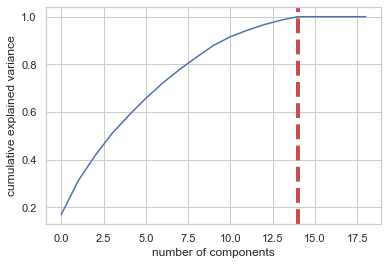

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.171126,0.171126
1,0.312301,0.141175
2,0.418041,0.105740
3,0.510279,0.092239
4,0.587000,0.076721
5,0.657989,0.070989
6,0.722161,0.064171
7,0.779115,0.056954
8,0.830465,0.051351
9,0.879773,0.049308


In [ ]:
#Outlier removal -> smote -> pca
pca_test = PCA(n_components=19)
pca_test.fit(X_smote)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=14, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(15))

In [ ]:
pca = PCA(n_components=12)
X_smote = pca.fit_transform(X_smote)
X_test = pca.fit_transform(X_test)

# Naive Bayes (SMOTE)

In [ ]:
#Gaussian
bNB = GaussianNB()
bNB.fit(X_smote, y_smote)
y_bNB_pred = bNB.predict(X_test)
y_bNB_prob = bNB.predict_proba(X_test)[:,1]

In [ ]:
accuracy_bNB = accuracy_score(y_test, y_bNB_pred)
roc = roc_auc_score(y_test, y_bNB_pred)
cm = confusion_matrix(y_test, y_bNB_pred)
print(classification_report(y_test, y_bNB_pred))

              precision    recall  f1-score   support

           0       0.96      0.41      0.57       969
           1       0.06      0.66      0.11        53

    accuracy                           0.42      1022
   macro avg       0.51      0.53      0.34      1022
weighted avg       0.91      0.42      0.55      1022



ROC AUC score: 0.5345230445703604
Accuracy Score:  0.4217221135029354


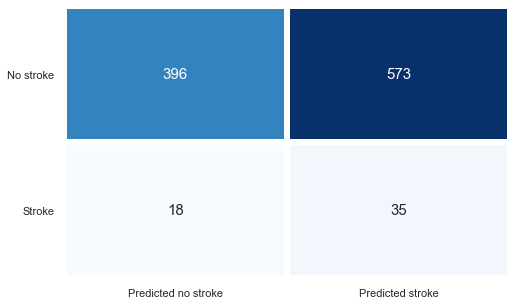

Text(0.5, 0, 'False Positive Rate')

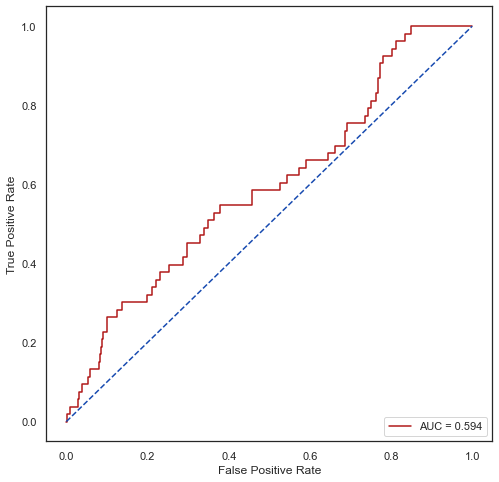

In [ ]:
print(f'ROC AUC score: {roc_auc_score(y_test, y_bNB_pred)}')
print('Accuracy Score: ',accuracy_score(y_test, y_bNB_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_bNB_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Tuning  GridSearch

In [ ]:
grid_models =  [(GaussianNB(),[{'var_smoothing': [0.19,0.1,0.11,1e-13,1e-12,1e-11,1e-10,1e-09,1e-08,1e-07]}]), 
               (BernoulliNB(), [{'alpha': [0.25, 0.5, 0.75, 1]}])]

In [ ]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'roc_auc',cv = 10)
    grid.fit(X_smote, y_smote)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest ROC AUC : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

GaussianNB():
Best ROC AUC : 80.05%
Best Parameters :  {'var_smoothing': 0.19}

----------------

BernoulliNB():
Best ROC AUC : 74.93%
Best Parameters :  {'alpha': 1}

----------------



# After tuning GridSearch

In [ ]:
#Bernoulli
#bNB = BernoulliNB(alpha=0.25)
bNB = GaussianNB(var_smoothing= 0.19)
#bNB = MultinomialNB()
bNB.fit(X_smote, y_smote)
y_bNB_pred = bNB.predict(X_test)
y_bNB_prob = bNB.predict_proba(X_test)[:,1]

In [ ]:
accuracy_bNB = accuracy_score(y_test, y_bNB_pred)
roc = roc_auc_score(y_test, y_bNB_pred)
cm = confusion_matrix(y_test, y_bNB_pred)
print(classification_report(y_test, y_bNB_pred))

              precision    recall  f1-score   support

           0       0.96      0.39      0.55       969
           1       0.06      0.72      0.11        53

    accuracy                           0.40      1022
   macro avg       0.51      0.55      0.33      1022
weighted avg       0.91      0.40      0.53      1022



ROC AUC score: 0.5519890180501197
Accuracy Score:  0.4041095890410959


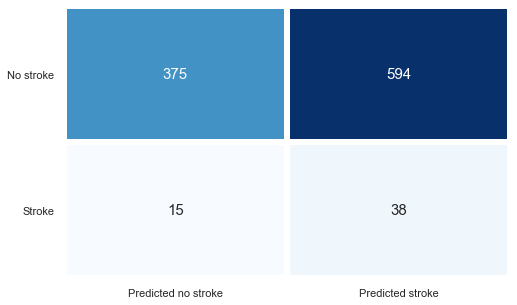

Text(0.5, 0, 'False Positive Rate')

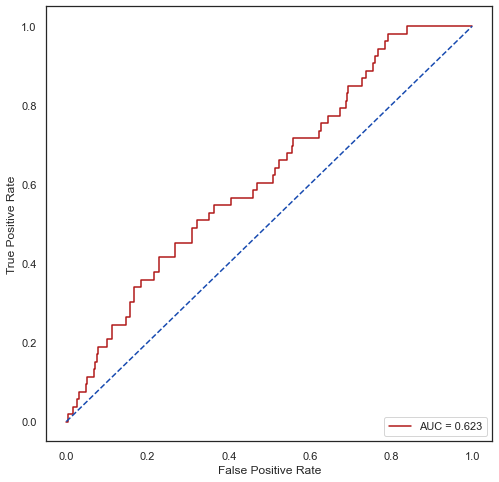

In [ ]:
print(f'ROC AUC score: {roc_auc_score(y_test, y_bNB_pred)}')
print('Accuracy Score: ',accuracy_score(y_test, y_bNB_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_bNB_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
print(f'ROC AUC score: {roc_auc_score(y_test, y_bNB_pred)}')
print('Accuracy Score: ',accuracy_score(y_test, y_bNB_pred))
print('Precision Score:', precision_score(y_test, y_bNB_pred))
print('Recall Score:', recall_score(y_test, y_bNB_pred))
print('F1 Score:', f1_score(y_test, y_bNB_pred))
print('----------------------------------------------------------')
print(classification_report(y_test, y_bNB_pred))

ROC AUC score: 0.5519890180501197
Accuracy Score:  0.4041095890410959
Precision Score: 0.060126582278481014
Recall Score: 0.7169811320754716
F1 Score: 0.11094890510948906
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.39      0.55       969
           1       0.06      0.72      0.11        53

    accuracy                           0.40      1022
   macro avg       0.51      0.55      0.33      1022
weighted avg       0.91      0.40      0.53      1022

